# Image Captioning Computer Vision.

Name: Anthony Kevin Oktavius

Paper and Dataset can be found at this link: https://paperswithcode.com/dataset/flickrstyle10k

Library Import

In [25]:
import numpy as np
import zipfile
import gc
import pickle
import cv2
import math
import warnings
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
# import torchmetrics
import torch.nn.functional as F
import PIL
import torch.utils.data as data_utils

# import pytorch_lightning as pl
import imutils
import zipfile

from PIL import Image
from torch.utils.data import Dataset
from collections import defaultdict
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from torchvision import models, transforms
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix, roc_curve
# from pytorch_lightning.loggers import TensorBoardLogger

## Data Preparation

Download and Unzip the Dataset

In [3]:
! cp ./kaggle.json ~/.kaggle/
! kaggle datasets download -d adityajn105/flickr8k
! unzip -qq ./flickr8k.zip -d ./Dataset

100% 1.03G/1.04G [00:13<00:00, 138MB/s]
100% 1.04G/1.04G [00:13<00:00, 81.7MB/s]


## Data Preprocessing

Prepare ImageFolder

In [18]:
train_transform = transforms.Compose([
    transforms.CenterCrop((320, 320)),
    transforms.Resize((128, 128)), # Mitigate if there's a "RAM is not enough" error.
    transforms.RandomRotation(degrees = 5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
    # ),
])

val_transform = transforms.Compose([
    transforms.CenterCrop((224, 224)),
    transforms.Resize((128, 128)), # Mitigate if there's a "RAM is not enough" error.
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
    # ),
])

In [21]:
captions_iterator = open("Dataset/captions.txt", 'r')

image_name_to_labels_dict = defaultdict(list)
image_paths = defaultdict()

for text_per_line in captions_iterator.readlines()[1:]:
  image_name, label = text_per_line.split(".jpg,")
  image_name = f"{image_name}.jpg"
  label = label.strip("\n")

  image_name_to_labels_dict[image_name].append(label)

print("Example image_name to label dict: ")
print(image_name_to_labels_dict["1000268201_693b08cb0e.jpg"])
captions_iterator.close()

Example image_name to label dict: 
['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


Gather all image names, then train test split 80% and 20%.

In [19]:
image_paths = os.listdir("/content/Dataset/Images/")
TOTAL_AMOUNT_OF_DATA = len(image_paths)

NUMBER_OF_TRAIN_DATA = int(0.8 * TOTAL_AMOUNT_OF_DATA)
NUMBER_OF_VAL_DATA = TOTAL_AMOUNT_OF_DATA - NUMBER_OF_TRAIN_DATA

# Get the train and val images.
train_image_names = image_paths[:NUMBER_OF_TRAIN_DATA]
val_image_names = image_paths[NUMBER_OF_TRAIN_DATA:NUMBER_OF_TRAIN_DATA+NUMBER_OF_VAL_DATA]

print(train_image_names[:10])
print(val_image_names[:10])

['3211029717_2affe6bbd5.jpg', '2754271176_4a2cda8c15.jpg', '3122938209_2b2c6c1fab.jpg', '3265162450_5b4e3c5f1b.jpg', '2708582445_5e5999b956.jpg', '318070878_92ead85868.jpg', '3329858093_0ec73f2190.jpg', '160805827_5e6646b753.jpg', '3089842255_359ccf5c40.jpg', '2056377805_e9a9b3bcf0.jpg']
['3356748019_2251399314.jpg', '3041487045_b48ac7ed08.jpg', '2533010184_ef2fd71297.jpg', '3457315666_b943111dec.jpg', '515755283_8f890b3207.jpg', '3667492609_97f88b373f.jpg', '3113322995_13781860f2.jpg', '2837808847_5407af1986.jpg', '502884177_25939ac000.jpg', '1262583859_653f1469a9.jpg']


## Data Preparation

In [33]:
NUMBER_OF_LABELS_PER_SAMPLE = 5
DATASET_BASE_PATH = "/content/Dataset/Images"

class FlickrStyleDataset(Dataset):
  def __init__(self, base_path, image_names, image_name_to_labels_dict, image_transform, number_of_labels_per_sample):
    super(FlickrStyleDataset, self).__init__()
    self.base_path = base_path
    self.image_names = image_names
    self.image_name_to_labels_dict = image_name_to_labels_dict
    self.image_transform = image_transform
    self.number_of_labels_per_sample = number_of_labels_per_sample

  def __getitem__(self, image_index):
    image_name = self.image_names[image_index]
    image_path = f"{self.base_path}/{image_name}"
    image = Image.open(image_path)

    if self.image_transform:
      image = self.image_transform(image)

    label = self.image_name_to_labels_dict[image_name]

    return image, label

  def __len__(self):
    return len(self.image_names)

flickr_train_dataset = FlickrStyleDataset(
    DATASET_BASE_PATH,
    train_image_names,
    image_name_to_labels_dict,
    train_transform,
    NUMBER_OF_LABELS_PER_SAMPLE
)

flickr_val_dataset = FlickrStyleDataset(
    DATASET_BASE_PATH,
    val_image_names,
    image_name_to_labels_dict,
    train_transform,
    NUMBER_OF_LABELS_PER_SAMPLE
)

print(flickr_train_dataset[0][0].shape)
print(flickr_val_dataset[0][1])

torch.Size([3, 128, 128])
['Cyclists are leaping into the air whilst being watched by spectators .', 'Three dirt bike racers head over a jump .', 'Three men form an arch during a BMX bike race sponsored by Coca-Cola .', 'Three men on mountain bikes go over a sand hill .', 'Three riders wearing black jerseys jump their BMX bikes into the air .']


Generate a dataset loader.

In [35]:
flickr_train_dataloader = torch.utils.data.DataLoader(
    flickr_train_dataset,
    batch_size = 4,
    shuffle = True,
)

flickr_val_dataloader = torch.utils.data.DataLoader(
    flickr_val_dataset,
    batch_size = 4,
    shuffle = True,
)

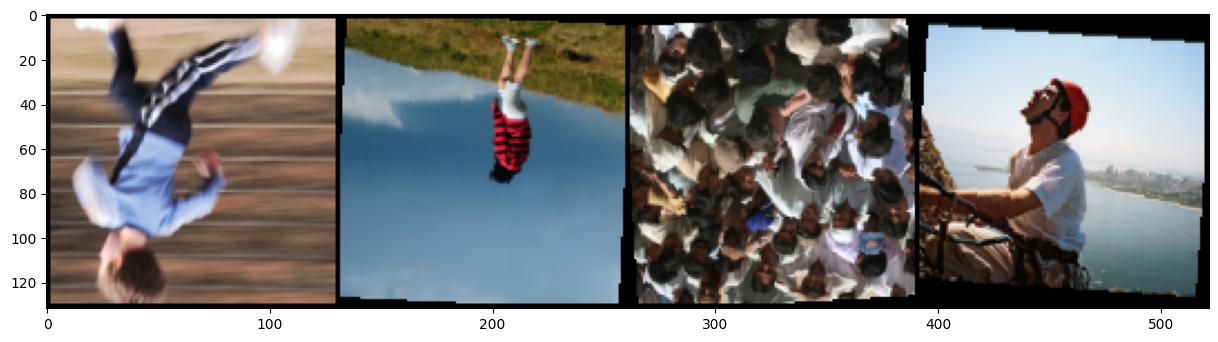

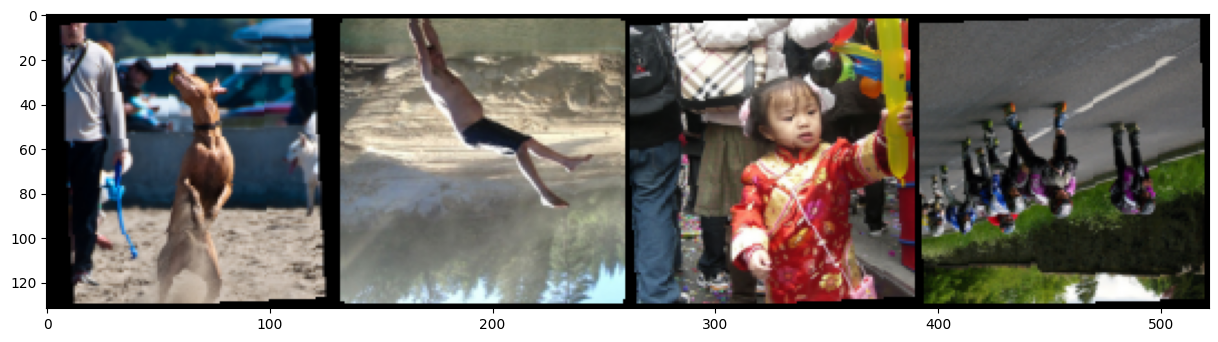

In [39]:
def plot_images_in_grid(title, images, labels, figsize = (15, 15), MIN_INDEX_PLOT = 0, MAX_INDEX_PLOT = 20):
  plt.figure(figsize = figsize)
  plt.suptitle(title)
  for index in range(MIN_INDEX_PLOT, MAX_INDEX_PLOT):
    plt.subplot(5, 5, index + 1)
    plt.axis('off')
    plt.text(x = 10, y = 0.5, s = labels[index], fontsize = 10, bbox = dict(facecolor = 'white'))
    plt.imshow(images[index], cmap = 'gray')

def visualize_pytorch_grid(images_in_batch):
  plt.figure(figsize = (15, 15))
  grid_images_in_batch = torchvision.utils.make_grid(images_in_batch)
  plt_compatible_grid_images_in_batch = np.transpose(grid_images_in_batch.numpy(), (1, 2, 0))
  plt.imshow(plt_compatible_grid_images_in_batch)

def visualize_dataloader(data_loader, title):
  iter_loader = iter(data_loader)
  input_image_in_batch, _ = next(iter_loader)

  visualize_pytorch_grid(input_image_in_batch)

visualize_dataloader(flickr_train_dataloader, "Train Transformed Image")
visualize_dataloader(flickr_val_dataloader, "Validation Transformed Image")

## Data Modelling

In [ ]:
class Seq2SeqImageCaptioningModel(nn.Module):
  def __init__(self):
    self.

  def forward():
    pass